In [2]:
%matplotlib inline
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import statsmodels.api as sm
import torch

import pyro
from pyro.distributions import Delta
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

from model4_5 import model

pyro.set_rng_seed(1234)
# Enable validation checks
pyro.enable_validation(True)


## 4.4 単回帰モデル

年齢と年収の関係性をモデリングする．

年収$ y_{base} $とそれ以外の影響である$\epsilon$の和であるとする

In [4]:
d = pd.read_csv('input/data-salary.txt').astype('float32')

In [5]:
d

,X,Y
0,24.0,472.0
1,24.0,403.0
2,26.0,454.0
3,32.0,575.0
4,33.0,546.0
5,35.0,781.0
6,38.0,750.0
7,40.0,601.0
8,40.0,814.0
9,43.0,792.0


### fig4-2

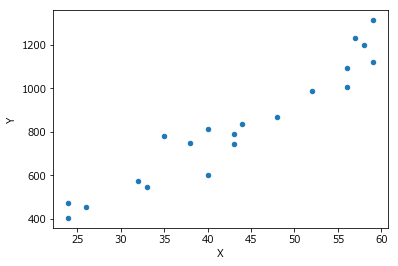

In [6]:
d.plot(kind="scatter", x="X", y="Y")

### モデル式

$$ Y[n] = y_{base}[n] + \epsilon [n] \; n=1,2,\dots,N$$
$$y_{base}[n] = a + b X[n] \; n=1,2,\dots,N$$
$$\epsilon [n] \sim Normal(0, \sigma) \; n=1,2,\dots,N$$

ただし，$N$は人数，$Y[n]$は年収，$y_{base}[n]$は基本年収，$X[n]$は年齢を表す．添字$n$は人のインデックス．

$$Y[n] \sim Normal(a + b X[n], \sigma) \; n=1,2,\dots,N$$


In [7]:
x = sm.add_constant(d.X)
res_lm = sm.OLS(d.Y, x).fit()

In [8]:
x

,const,X
0,1.0,24.0
1,1.0,24.0
2,1.0,26.0
3,1.0,32.0
4,1.0,33.0
5,1.0,35.0
6,1.0,38.0
7,1.0,40.0
8,1.0,40.0
9,1.0,43.0


In [9]:
res_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     208.2
Date:                Sun, 27 Jan 2019   Prob (F-statistic):           2.47e-11
Time:                        14:52:08   Log-Likelihood:                -114.74
No. Observations:                  20   AIC:                             233.5
Df Residuals:                      18   BIC:                             235.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -119.6971     68.148     -1.756      0.096    -262.871      23.477
X             21.9042      1.518     14.428      0.000      18.715      25.094
==============================================================================
Omnibus:                        0.099   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.952   Jarque-Bera (JB):                0.216
Skew:                           0.140   Prob(JB):                        0.898
Kurtosis:                       2.575   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
new_x = sm.add_constant(range(23, 61))
summary = res_lm.get_prediction(new_x).summary_frame(alpha=0.05)
summary2 = res_lm.get_prediction(new_x).summary_frame(alpha=0.5)

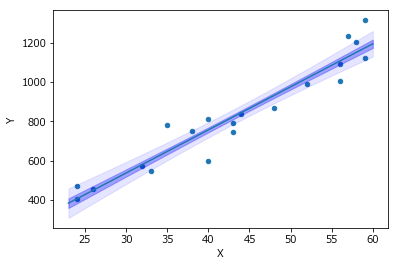

In [11]:
d.plot(kind="scatter", x="X", y="Y")
plt.plot(range(23, 61), summary["mean"])
plt.fill_between(range(23, 61), summary["mean_ci_lower"],summary["mean_ci_upper"], color='blue', alpha=0.1)
plt.fill_between(range(23, 61), summary2["mean_ci_lower"],summary2["mean_ci_upper"],color='blue', alpha=0.3)

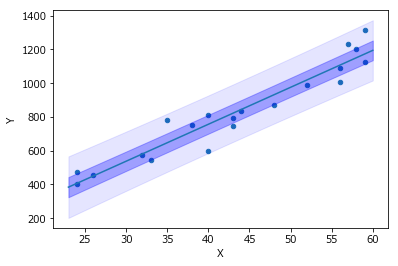

In [12]:
d.plot(kind="scatter", x="X", y="Y")
plt.plot(range(23, 61), summary["mean"])
plt.fill_between(range(23, 61), summary["obs_ci_lower"],summary["obs_ci_upper"], color='blue', alpha=0.1)
plt.fill_between(range(23, 61), summary2["obs_ci_lower"],summary2["obs_ci_upper"],color='blue', alpha=0.3)

## MCMC

In [76]:
torch_d = torch.tensor(d.values)
x_data, y_data = torch_d[:, 0], torch_d[:, -1]

nuts_kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
hmc_posterior = MCMC(nuts_kernel, num_samples=1000, num_chains=4, warmup_steps=1000).run(x_data, y_data)

In [77]:
def summary(traces, sites):
#    ∑_x p(a,b,sigma|x)p(x) shape=(1000, 3)
    marginal = EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].reshape(-1, len(sites)).detach().cpu().numpy()
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats


sites = ["a", "b", "sigma"]

for site, values in summary(hmc_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")


Site: a
        mean        std          5%        25%        50%        75%  \
0 -81.172485  57.817947 -174.216054 -118.38434 -82.043789 -44.699757   

         95%  
0  16.385697   

Site: b
        mean       std        5%        25%        50%        75%        95%
0  21.079649  1.303268  18.90625  20.250106  21.079851  21.924326  23.192491 

Site: sigma
        mean        std         5%        25%        50%        75%        95%
0  80.607658  10.326903  63.543496  72.865664  80.721222  88.828947  97.041479 



In [92]:
posterior_a = EmpiricalMarginal(hmc_posterior, 'a')
posterior_b = EmpiricalMarginal(hmc_posterior, 'b')
posterior_sigma = EmpiricalMarginal(hmc_posterior, 'sigma')

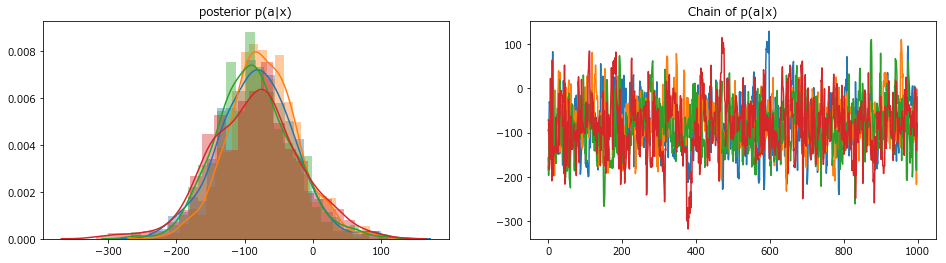

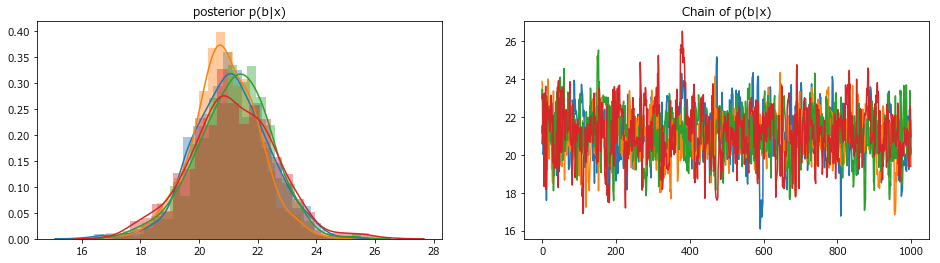

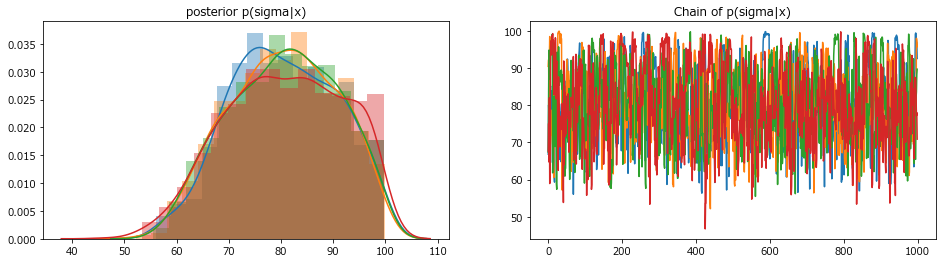

In [91]:
plt.figure(figsize=(16, 4))
plt.subplot(121)b
plt.title("posterior p(a|x)")
for i in range(4):
    sns.distplot(posterior_a._get_samples_and_weights()[0][i])
plt.subplot(122)
plt.title("Chain of p(a|x)")
for i in range(4):
    plt.plot(range(1000), posterior_a._get_samples_and_weights()[0][i].numpy())

    
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title("posterior p(b|x)")
for i in range(4):
    sns.distplot(posterior_b._get_samples_and_weights()[0][i])
plt.subplot(122)
plt.title("Chain of p(b|x)")
for i in range(4):
    plt.plot(range(1000), posterior_b._get_samples_and_weights()[0][i].numpy())
    
    
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title("posterior p(sigma|x)")
for i in range(4):
    sns.distplot(posterior_sigma._get_samples_and_weights()[0][i])
plt.subplot(122)
plt.title("Chain of p(sigma|x)")
for i in range(4):
    plt.plot(range(1000), posterior_sigma._get_samples_and_weights()[0][i].numpy())

In [103]:
ms = EmpiricalMarginal(hmc_posterior, ["a", "b", "sigma"])._get_samples_and_weights()[0].reshape(-1, 3).detach().cpu().numpy()
d_mcmc = pd.DataFrame(ms)
d_mcmc.columns = ["a", "b", "sigma"]

In [106]:
d_mcmc.head()

,a,b,sigma
0,-93.094086,21.159458,66.845627
1,-98.398491,21.565493,80.084267
2,-76.771782,20.994724,76.903114
3,-30.327494,20.025866,67.111496
4,-35.218887,20.099216,65.126060


In [104]:
d_mcmc.quantile([0.025, 0.975])

,a,b,sigma
0.025,-191.647905,18.41144,60.935368
0.975,34.690238,23.57921,98.355399


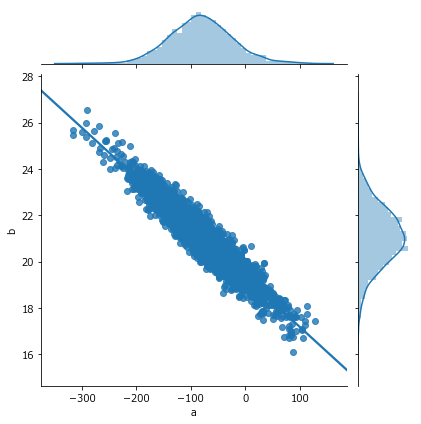

In [108]:
sns.jointplot(x="a", y="b", data=d_mcmc, kind="reg")

In [141]:
X_new = range(23, 61)
y_base_mcmc = pd.DataFrame([])
y_mcmc = pd.DataFrame([])

for age in X_new:
    y_base_mcmc[age] = d_mcmc.a.values + d_mcmc.b.values * age
    y_mcmc[age] = dist.Normal(torch.tensor(y_base_mcmc[age].values), torch.tensor(d_mcmc.sigma.values)).sample()

In [154]:
y_base_mcmc_quantile = y_base_mcmc.quantile([0.025, 0.25, 0.5, 0.75, 0.975])
y_mcmc_quantile = y_mcmc.quantile([0.025, 0.25, 0.5, 0.75, 0.975])

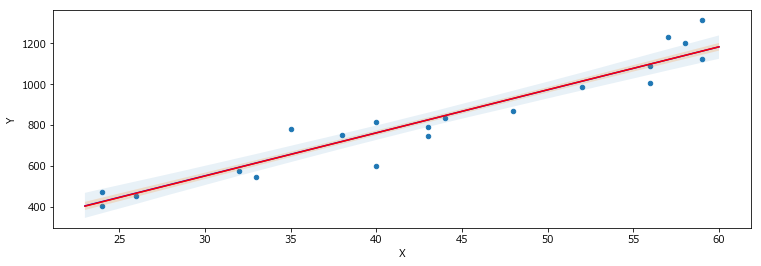

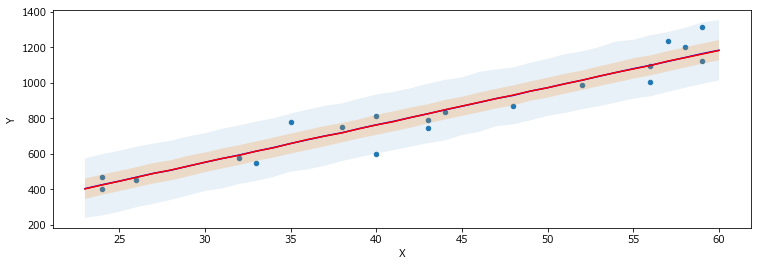

In [164]:
d.plot(kind="scatter", x="X", y="Y", figsize=(12.5, 4))
plt.plot(range(23, 61), y_base_mcmc.mean(axis=0), 'b')
plt.plot(range(23, 61), y_base_mcmc_quantile.loc[0.5], 'r')
plt.fill_between(range(23, 61), y_base_mcmc_quantile.loc[0.025].values, y_base_mcmc_quantile.loc[0.975].values, alpha=0.1)
plt.fill_between(range(23, 61), y_base_mcmc_quantile.loc[0.25].values, y_base_mcmc_quantile.loc[0.75].values, alpha=0.2)

d.plot(kind="scatter", x="X", y="Y", figsize=(12.5, 4))
plt.plot(range(23, 61), y_mcmc.mean(axis=0), 'b')
plt.plot(range(23, 61), y_mcmc_quantile.loc[0.5], 'r')
plt.fill_between(range(23, 61), y_mcmc_quantile.loc[0.025].values, y_mcmc_quantile.loc[0.975].values, alpha=0.1)
plt.fill_between(range(23, 61), y_mcmc_quantile.loc[0.25].values, y_mcmc_quantile.loc[0.75].values, alpha=0.2)

## Posterior-Predictive Distribution/事後予測分布

In [176]:
from pyro import distributions as dist
def predict_model(x):
    a = pyro.sample("a", dist.Normal(0, 100))
    b = pyro.sample("b", dist.Normal(0, 100))

    sigma = pyro.sample("sigma", dist.Uniform(0., 100))

    pyro.sample("predict", dist.Normal(a + b * x, sigma))

test_data = torch.tensor(range(23, 61)).float()
hmc_predictive = TracePredictive(predict_model,
                                 hmc_posterior,
                                 num_samples=1000)
post_pred = hmc_predictive.run(test_data)
post_summary = summary(post_pred, sites=['predict'])

In [177]:
post_summary

{'predict':          mean         std          5%         25%         50%         75%  \
 0  793.837158  245.876587  404.605498  592.864517  795.131287  993.862045   
 
            95%  
 0  1180.221436  }

In [262]:
pred_mcmc = pd.DataFrame(EmpiricalMarginal(post_pred, "predict")._get_samples_and_weights()[0].detach().cpu().numpy())
pred_mcmc.columns = list(range(23, 61))
pred_mcmc_quantile = pred_mcmc.quantile([0.025, 0.25, 0.5, 0.75, 0.975])

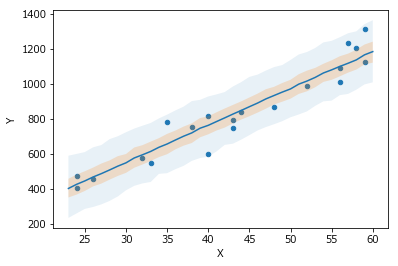

In [270]:
d.plot(kind="scatter", x="X", y="Y")
plt.plot(pred_mcmc.columns.values, pred_mcmc.mean(axis=0))
plt.fill_between(pred_mcmc.columns.values, pred_mcmc_quantile.loc[0.025], pred_mcmc_quantile.loc[0.975], alpha=0.1) 
plt.fill_between(pred_mcmc.columns.values, pred_mcmc_quantile.loc[0.25], pred_mcmc_quantile.loc[0.75], alpha=0.2) 